In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
shows = pd.read_csv("Anime Data 2/anime_filtered.csv", index_col = 'anime_id', usecols=['title', 'anime_id'])
ratings = pd.read_csv("Anime Data 2/animelists_filtered.csv", nrows = 200000,usecols=['username', 'anime_id', 'my_score'])

In [3]:
ratings.head()

,username,anime_id,my_score
0,karthiga,21,9
1,RedvelvetDaisuki,21,0
2,Damonashu,21,10
3,bskai,21,8
4,Slimak,21,10


In [4]:
ratings.shape

(200000, 3)

#### Pivoting the data so that I have the users as rows with shows at the columns and their scores as the values

In [5]:
ratings = pd.pivot(ratings, index = 'username', columns = 'anime_id', values = 'my_score')

In [6]:
ratings.head()

anime_id,21,59,74,120,178,210,232,233,249
username,,,,,,,,,
----phoebelyn,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
--AnimeBoy--,6.0,6.0,6.0,NaN,NaN,7.0,7.0,NaN,NaN
--CyberShadow--,9.0,NaN,8.0,9.0,NaN,NaN,NaN,NaN,NaN
--FallenAngel--,9.0,8.0,NaN,NaN,NaN,8.0,NaN,NaN,8.0
--Kin--,10.0,NaN,NaN,7.0,NaN,NaN,8.0,NaN,NaN


#### Pick the shows that I want to focus in on for these recommendations

In [7]:
target_cols = [210, 232, 233]
non_targets = [col for col in ratings.columns if col not in target_cols]
target_cols

[210, 232, 233]

#### The names of the shows that I am targeting to determine if should reccommend

In [8]:
shows.loc[target_cols, 'title']

anime_id
210              Ranma ½
232    Cardcaptor Sakura
233       Daa! Daa! Daa!
Name: title, dtype: object

In [9]:
ratings = ratings.loc[ratings[target_cols].notna().max(axis=1)
                     & (ratings.drop(target_cols, axis=1).notna().sum(axis=1)>0)]

In [10]:
ratings[target_cols].notna().mean()

anime_id
210    0.488273
232    0.771060
233    0.079712
dtype: float64

### Plotting the distribution of the ratings for my target shows

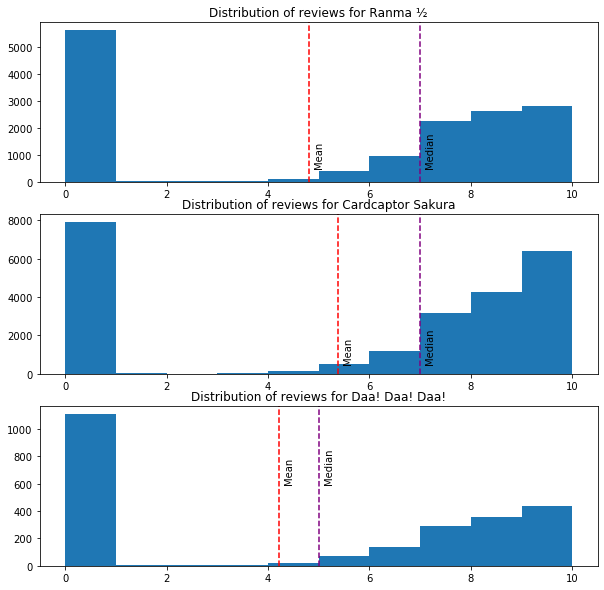

In [11]:
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.title("Distribution of reviews for {}".format(shows.loc[target_cols[0], 'title']))
plt.hist(ratings[target_cols[0]].dropna())
plt.axvline(ratings[target_cols[0]].median(), color='purple', ls='--')
plt.text(ratings[target_cols[0]].median()+0.1, ratings[target_cols[2]].count()/4, 'Median', rotation = 90)
plt.axvline(ratings[target_cols[0]].mean(), color = 'red', ls = '--')
plt.text(ratings[target_cols[0]].mean()+0.1, ratings[target_cols[2]].count()/4, 'Mean', rotation = 90)



pyplot.subplot(312)
plt.title("Distribution of reviews for {}".format(shows.loc[target_cols[1], 'title']))
plt.hist(ratings[target_cols[1]].dropna())
plt.axvline(ratings[target_cols[1]].median(), color='purple', ls='--')
plt.text(ratings[target_cols[1]].median()+0.1, ratings[target_cols[2]].count()/4, 'Median', rotation = 90)
plt.axvline(ratings[target_cols[1]].mean(), color = 'red', ls = '--')
plt.text(ratings[target_cols[1]].mean()+0.1, ratings[target_cols[2]].count()/4, 'Mean', rotation = 90)



pyplot.subplot(313)
plt.title("Distribution of reviews for {}".format(shows.loc[target_cols[2], 'title']))
plt.hist(ratings[target_cols[2]].dropna())
plt.axvline(ratings[target_cols[2]].median(), color='purple', ls='--')
plt.text(ratings[target_cols[2]].median()+0.1, ratings[target_cols[2]].count()/4, 'Median', rotation = 90)
plt.axvline(ratings[target_cols[2]].mean(), color = 'red', ls = '--')
plt.text(ratings[target_cols[2]].mean()+0.1, ratings[target_cols[2]].count()/4, 'Mean', rotation = 90)


pyplot.savefig('show_distribution.png',dpi=800)
plt.show()

#### Getting the training and testing sets

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=.3, random_state=1)

#### Creating a baseline error for the each of the shows that I am recommending to work from when altering it per user 

In [13]:
from sklearn.metrics import mean_absolute_error

# baseline (median)a
baselines = []

for target_col in target_cols:
    score = mean_absolute_error(test[target_col].dropna(),
                    np.repeat(train[target_col].median(), test[target_col].notna().sum()))
    baselines.append(score)
    print("Error in scores when recommending '{}' (median baseline): {}".format(shows.loc[target_col, 'title'],
        round(score, 2)))

Error in scores when recommending 'Ranma ½' (median baseline): 3.5
Error in scores when recommending 'Cardcaptor Sakura' (median baseline): 3.3
Error in scores when recommending 'Daa! Daa! Daa!' (median baseline): 3.93


## Collaborative Filtering

In [14]:
train_targets = train[target_cols]
test_targets = test[target_cols]

train = train.drop(target_cols, axis=1)
test = test.drop(target_cols, axis=1)

#### Zero Center the review values by user using their average for the training and testing

In [15]:
train_mean = train.mean(axis=1)
test_mean = test.mean(axis=1)

train = train.apply(lambda col:col-train_mean)
test = test.apply(lambda col:col-test_mean)

train_targets = train_targets.apply(lambda col:col-train_mean)
test_targets = test_targets.apply(lambda col:col-test_mean)

#### Find the similarity between users so that we can know which users are similar for recommendations

In [16]:
# find inter-user similarity (ignoring our target columns)
from sklearn.metrics.pairwise import cosine_similarity

sim = pd.DataFrame(cosine_similarity(train.fillna(0), test.fillna(0)), 
                   index=train.index, columns=test.index)
sim.shape

(21488, 9210)

In [17]:
sim.head()

username,Mifu,KIIRA,Rigix,05chante,RazorBladeHeart,Krold,aoitenshi,MichieruChan,youav97,AzukeN-kun,...,Saberclaws,InSoManX,elberino,DevilLady,VinaKoolkat,sumikk0,ericssj,Nekko-mimi,alexinwonderland,Agusloquillo
username,,,,,,,,,,,,,,,,,,,,,
LelouchStampede,0.0,0.0,0.0,0.817057,-2.886751e-01,-0.223607,0.816497,0.632456,0.0,0.000000e+00,...,0.517088,0.000000e+00,0.0,-0.917663,0.756596,0.716910,0.0,0.790569,0.0,-0.500000
Jen526,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
sloneczniq,0.0,0.0,0.0,0.200959,-4.564355e-01,0.494975,0.129099,1.000000,0.0,3.867427e-18,...,0.179869,-6.797661e-18,0.0,-0.798024,0.039876,0.408072,0.0,0.050000,0.0,0.158114
wyspa,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
Genki_Dama,0.0,0.0,0.0,-0.909101,-2.490864e-16,0.707107,-0.968246,-0.050000,0.0,1.581139e-01,...,-0.531432,2.726547e-18,0.0,0.544107,-0.890567,-0.549134,0.0,-1.000000,0.0,0.790569


In [18]:
pred_single_preadj_above = 0
pred_single_preadj_below = 0
pred_multiple_preadj_above = 0
pred_multiple_preadj_below = 0
for target_col, baseline in zip(target_cols, baselines):
    # actual ratings for first target show (for those users in the test set who rated it)
    actual = (test_targets[target_col]+test_mean).dropna()
    
    # get the most similar user's adjustment on this show, 
    ## then apply that adjustment to the unknown user's avg score
    pred_single = sim.loc[train_targets[target_col].notna(), test_targets[target_col].notna()].apply(lambda col:
                          train_targets.loc[col.idxmax(), target_col] if col.max()>0 else 0)+test_mean.reindex(actual.index)
    
    pred_multiple = sim.loc[train_targets[target_col].notna(), test_targets[target_col].notna()].apply(lambda col:
                          train_targets.loc[col.nlargest(25).index, target_col][col.nlargest(25)>0].mean()).fillna(0)+test_mean.reindex(actual.index)
    

    score_single_preadj = mean_absolute_error(actual,pred_single)
    score_multiple_preadj = mean_absolute_error(actual,pred_multiple)
    pred_single_preadj_above += sum(pred_single<0)
    pred_single_preadj_below += sum(pred_single>10)
    pred_multiple_preadj_above += sum(pred_multiple<0)
    pred_multiple_preadj_below += sum(pred_multiple>10)

    

    
    # adjust impossible scores
    pred_single[pred_single<0] = 0
    pred_single[pred_single>10] = 10
    pred_multiple[pred_multiple<0] = 0
    pred_multiple[pred_multiple>10] = 10


    
    score_single = mean_absolute_error(actual,pred_single)
    score_multiple = mean_absolute_error(actual,pred_multiple)
    
    print("Error in scores when recommending '{0}' (single user pre-adjust): {1}, decreasing the baseline error by{2:.1%}".format(shows.loc[target_col, 'title'],
        round(score_single_preadj, 2),
        (baseline-score_single_preadj)/baseline))
    print("Error in scores when recommending '{0}' (single most similar user): {1}, decreasing the baseline error by {2:.1%}".format(shows.loc[target_col, 'title'],
        round(score_single, 2),
        (baseline-score_single)/baseline))    
    print("Error in scores when recommending '{0}' (multiple user pre-adjust): {1}, decreasing the baseline error by{2:.1%}".format(shows.loc[target_col, 'title'], 
        round(score_multiple_preadj, 2), 
        (baseline-score_multiple_preadj)/baseline))
    print("Error in scores when recommending '{0}' (25 most similar users): {1}, decreasing the baseline error by {2:.1%}".format(shows.loc[target_col, 'title'],
        round(score_multiple, 2),
        (baseline-score_multiple)/baseline))
    print()

Error in scores when recommending 'Ranma ½' (single user pre-adjust): 3.32, decreasing the baseline error by5.1%
Error in scores when recommending 'Ranma ½' (single most similar user): 3.11, decreasing the baseline error by 11.2%
Error in scores when recommending 'Ranma ½' (multiple user pre-adjust): 2.73, decreasing the baseline error by22.0%
Error in scores when recommending 'Ranma ½' (25 most similar users): 2.73, decreasing the baseline error by 22.2%

Error in scores when recommending 'Cardcaptor Sakura' (single user pre-adjust): 3.42, decreasing the baseline error by-3.5%
Error in scores when recommending 'Cardcaptor Sakura' (single most similar user): 3.05, decreasing the baseline error by 7.7%
Error in scores when recommending 'Cardcaptor Sakura' (multiple user pre-adjust): 2.69, decreasing the baseline error by18.7%
Error in scores when recommending 'Cardcaptor Sakura' (25 most similar users): 2.67, decreasing the baseline error by 19.1%

Error in scores when recommending 'Daa

#### Quick Exploration of the number of guesses below 0 or above 10, both when using single predictor and multiple predictors

In [19]:
print("Using single most similar user {0} were below 0 and {1} were above 10".format(
    pred_single_preadj_below, pred_single_preadj_above))
    
print("Using multiple similar users {0} were below 0 and {1} were above 10".format(
    pred_multiple_preadj_below, pred_multiple_preadj_above))
print()
print("This shows how using multiple users keeps the predictions within a possible range, and shows why the adjustment")
print("of impossible values is so much more valuable if using the single user approach")

Using single most similar user 1380 were below 0 and 601 were above 10
Using multiple similar users 213 were below 0 and 26 were above 10

This shows how using multiple users keeps the predictions within a possible range, and shows why the adjustment
of impossible values is so much more valuable if using the single user approach


## Benefit of Collaborative Filtering, the ability of data size reduction

In [20]:
ratings.head()

anime_id,21,59,74,120,178,210,232,233,249
username,,,,,,,,,
--AnimeBoy--,6.0,6.0,6.0,NaN,NaN,7.0,7.0,NaN,NaN
--FallenAngel--,9.0,8.0,NaN,NaN,NaN,8.0,NaN,NaN,8.0
--Kin--,10.0,NaN,NaN,7.0,NaN,NaN,8.0,NaN,NaN
--RIE--,6.0,0.0,5.0,NaN,NaN,NaN,0.0,NaN,NaN
-0_o-,NaN,0.0,0.0,NaN,0.0,10.0,9.0,0.0,9.0


In [21]:
prev_mem = ratings.memory_usage().sum()
print("Current Dataset Shape: {}".format(ratings.shape))
print("Current memory usage: {} MB".format(round(prev_mem/(10**6), 2)))

Current Dataset Shape: (30698, 9)
Current memory usage: 2.46 MB


## Figure out how to shrink the dataset, grouping using NA values since that is the bulk of what any user row is comprised of

#### Creating a new df to work with to shrink in size, and fill the NaN values with -1 for grouping purposes

In [22]:
shrunk = ratings
shrunk.loc[:, non_targets] = shrunk.loc[:, non_targets].fillna(-1)

#### Grouping by non targets and the means of the target columns for each of those groups

In [23]:
targeted_columns = shrunk.groupby(non_targets)[target_cols].mean()
targeted_columns.head()

anime_id                           210       232  233
21   59   74   120  178  249                         
-1.0 -1.0 -1.0 -1.0 -1.0 0.0  2.319672  3.108247  3.8
                         2.0       NaN  7.000000  NaN
                         3.0  4.000000  3.333333  NaN
                         4.0  5.800000  4.583333  NaN
                         5.0  4.894737  5.080000  NaN

#### Grouping by Non_Targets and the size of those groups to have a weighting value for future of recommendations

In [24]:
Group_Weight = shrunk.groupby(non_targets).size().rename("Weight")

In [25]:
Group_Weight.head()

21    59    74    120   178   249
-1.0  -1.0  -1.0  -1.0  -1.0  0.0    264
                              2.0      1
                              3.0      7
                              4.0     19
                              5.0     37
Name: Weight, dtype: int64

### Using the code determined above to combine them to create the smaller dataset

In [26]:
shrunk = pd.concat([shrunk.groupby(non_targets)[target_cols].mean(), shrunk.groupby(non_targets).size().rename("Weight")], axis=1).reset_index().replace(-1, np.nan)

In [27]:
shrunk.head()

,21,59,74,120,178,249,210,232,233,Weight
0,NaN,NaN,NaN,NaN,NaN,0.0,2.319672,3.108247,3.8,264
1,NaN,NaN,NaN,NaN,NaN,2.0,NaN,7.000000,NaN,1
2,NaN,NaN,NaN,NaN,NaN,3.0,4.000000,3.333333,NaN,7
3,NaN,NaN,NaN,NaN,NaN,4.0,5.800000,4.583333,NaN,19
4,NaN,NaN,NaN,NaN,NaN,5.0,4.894737,5.080000,NaN,37


#### Comparing the two datasets in shape and memory

In [28]:
new_mem = shrunk.memory_usage().sum()
print("New Dataset Shape: {}".format(shrunk.shape))
print("New memory usage: {} MB".format(round(new_mem/(10**6), 2)))

New Dataset Shape: (7575, 10)
New memory usage: 0.61 MB


In [29]:
mem_ratio = (new_mem/prev_mem)*100
print("New Memory Percentage of Original: {}%".format(round(mem_ratio, 2)))

New Memory Percentage of Original: 24.68%


## Future version, use decreased size version with Weight as a value to increase weight behind any particular role